In [27]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

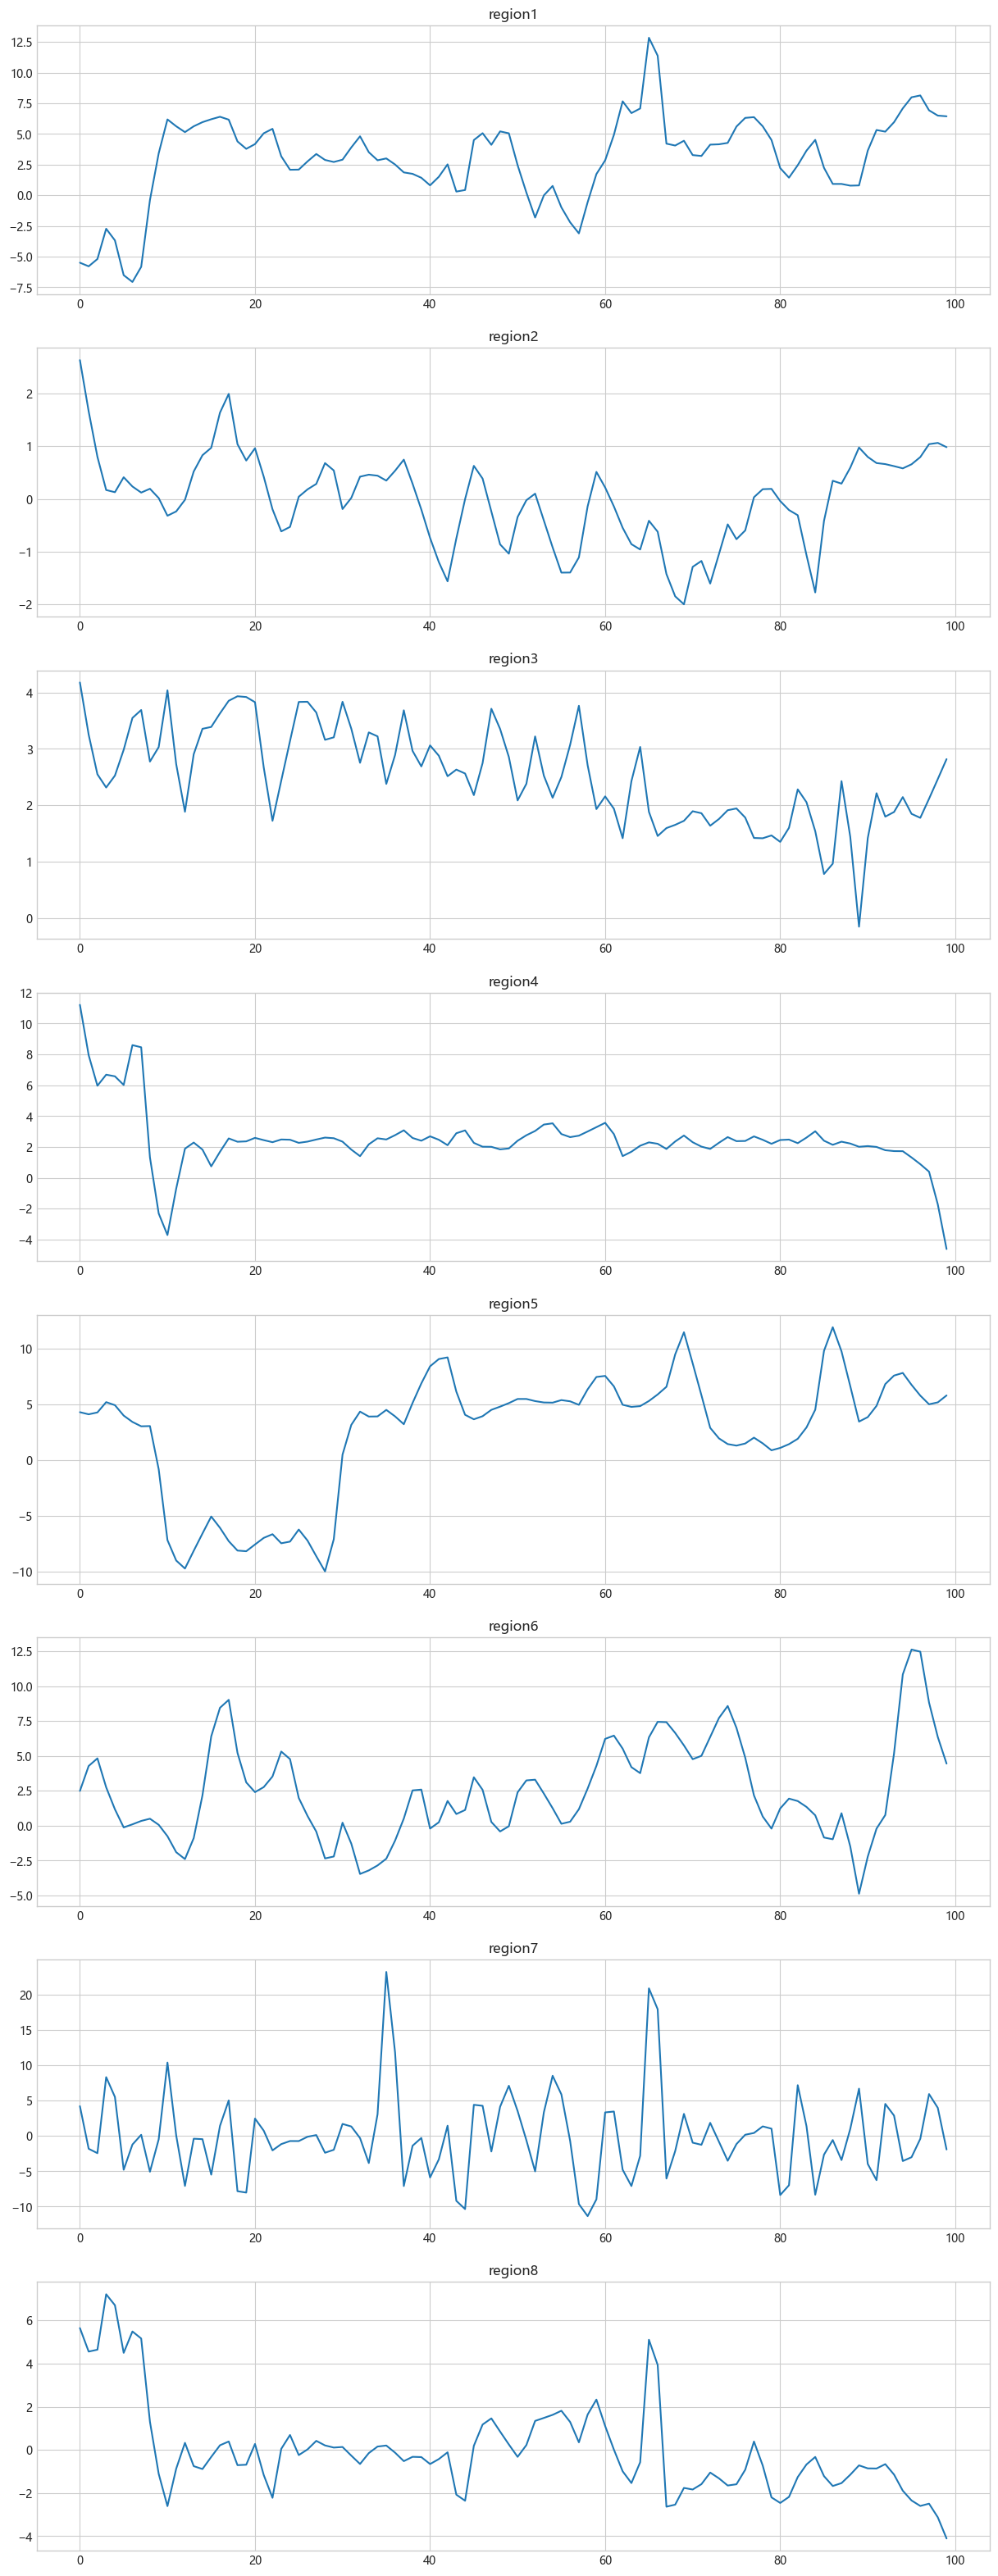

In [28]:
data = pd.read_excel('数据文件.xls')

# 数据分布
fig = plt.figure(figsize=(15, 40))
for i in range(1, 9):
    ax = fig.add_subplot(8, 1, i)
    ax.plot(data.iloc[:, i])
    ax.set_title('region%d' % i)

# plt.savefig('图片\原始数据图.png')

In [29]:
def ADF(ts):

    index = ['ADF统计值', 'p值', '临界值(1%)', '临界值(5%)', '临界值(10%)']
    df = pd.DataFrame(index=index, columns=['0阶差分', '1阶差分'])

    result = adfuller(ts)
    df['0阶差分'] = [result[0], result[1], result[4]['1%'], result[4]['5%'], result[4]['10%']]

    ts = ts.diff().dropna()
    result = adfuller(ts)
    df['1阶差分'] = [result[0], result[1], result[4]['1%'], result[4]['5%'], result[4]['10%']]

    return df

for i in range(1, 9):
    ts = data.iloc[:, i]
    print('='*30)
    print('region%d:' % i)

    # ADF检验数据
    print(ADF(ts))

region1:
              0阶差分      1阶差分
ADF统计值   -4.346335 -5.568501
p值        0.000369  0.000001
临界值(1%)  -3.501912 -3.501137
临界值(5%)  -2.892815 -2.892480
临界值(10%) -2.583454 -2.583275
region2:
              0阶差分      1阶差分
ADF统计值   -1.062038 -4.153298
p值        0.729971  0.000790
临界值(1%)  -3.506944 -3.508783
临界值(5%)  -2.894990 -2.895784
临界值(10%) -2.584615 -2.585038
region3:
              0阶差分          1阶差分
ADF统计值   -0.906856 -6.415095e+00
p值        0.785706  1.849679e-08
临界值(1%)  -3.504343 -3.504343e+00
临界值(5%)  -2.893866 -2.893866e+00
临界值(10%) -2.584015 -2.584015e+00
region4:
              0阶差分      1阶差分
ADF统计值    2.140717 -3.802654
p值        0.998830  0.002880
临界值(1%)  -3.506944 -3.505190
临界值(5%)  -2.894990 -2.894232
临界值(10%) -2.584615 -2.584210
region5:
              0阶差分          1阶差分
ADF统计值   -1.894497 -6.430970e+00
p值        0.334654  1.697811e-08
临界值(1%)  -3.499637 -3.500379e+00
临界值(5%)  -2.891831 -2.892152e+00
临界值(10%) -2.582928 -2.583100e+00
region6:
              0阶差分      1阶差分

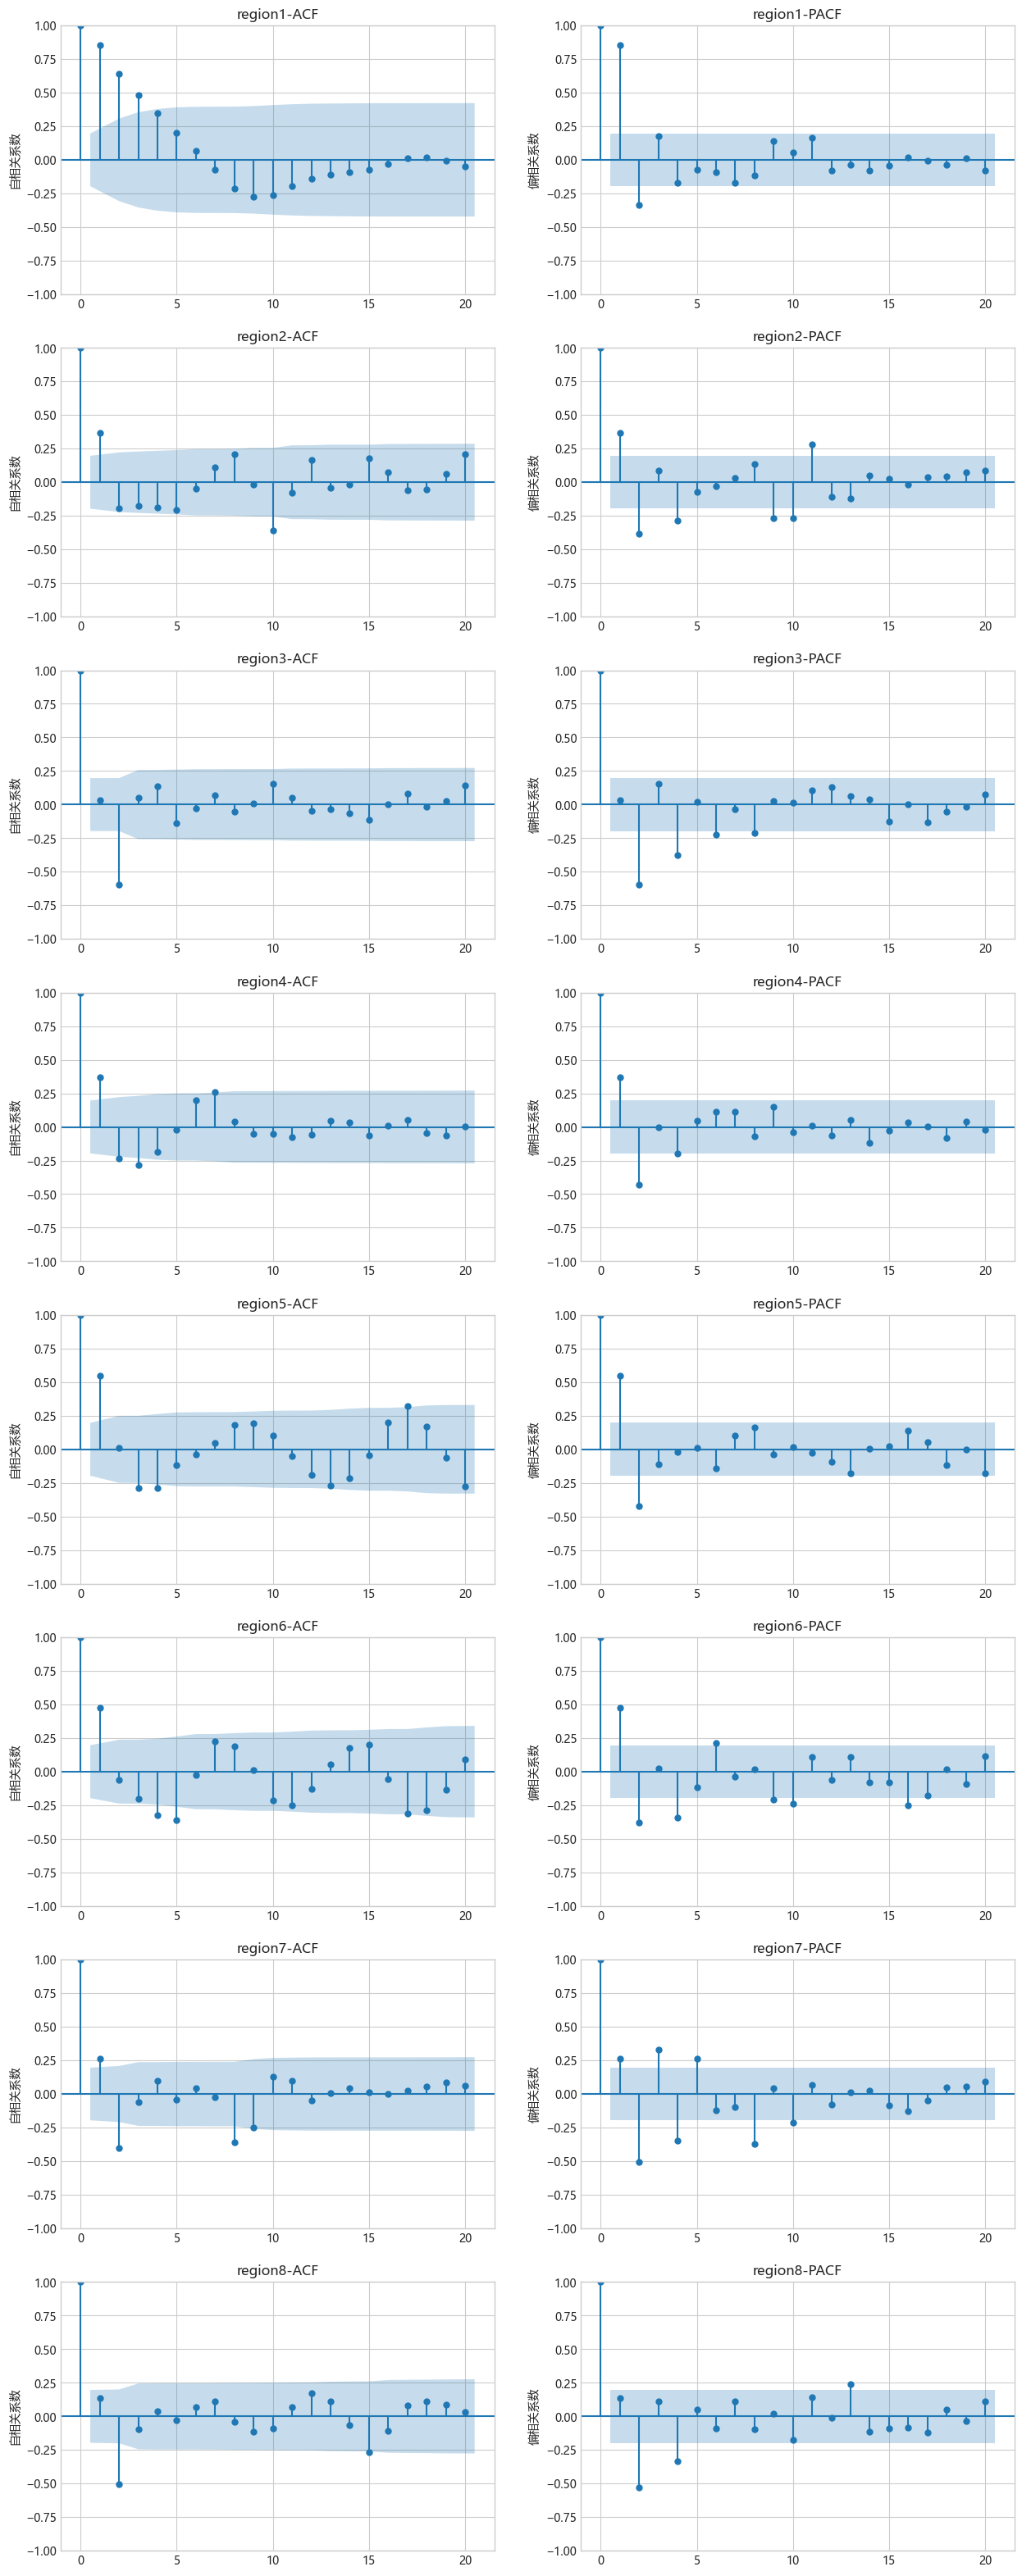

In [30]:
fig, ax = plt.subplots(8, 2, figsize=(15, 40))
diff_ = [0, 1, 1, 1, 1, 1, 0, 1]

for i in range(1, 9):

    # 绘制时间序列的ACF和PACF图
    # 图表每一行代表一个地区
    ts = data.iloc[:, i]
    if diff_[i - 1] == 1:
        ts = ts.diff().dropna()

    plot_acf(ts, ax=ax[i-1, 0])
    plot_pacf(ts, ax=ax[i-1, 1], method='ywm')
    ax[i-1, 0].set_title('region%d-ACF' % i)
    ax[i-1, 1].set_title('region%d-PACF' % i)
    ax[i-1, 0].set_ylabel('自相关系数')
    ax[i-1, 1].set_ylabel('偏相关系数')

# plt.savefig('图片\ACF和PACF图.png')

D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
D:\Anaconda\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


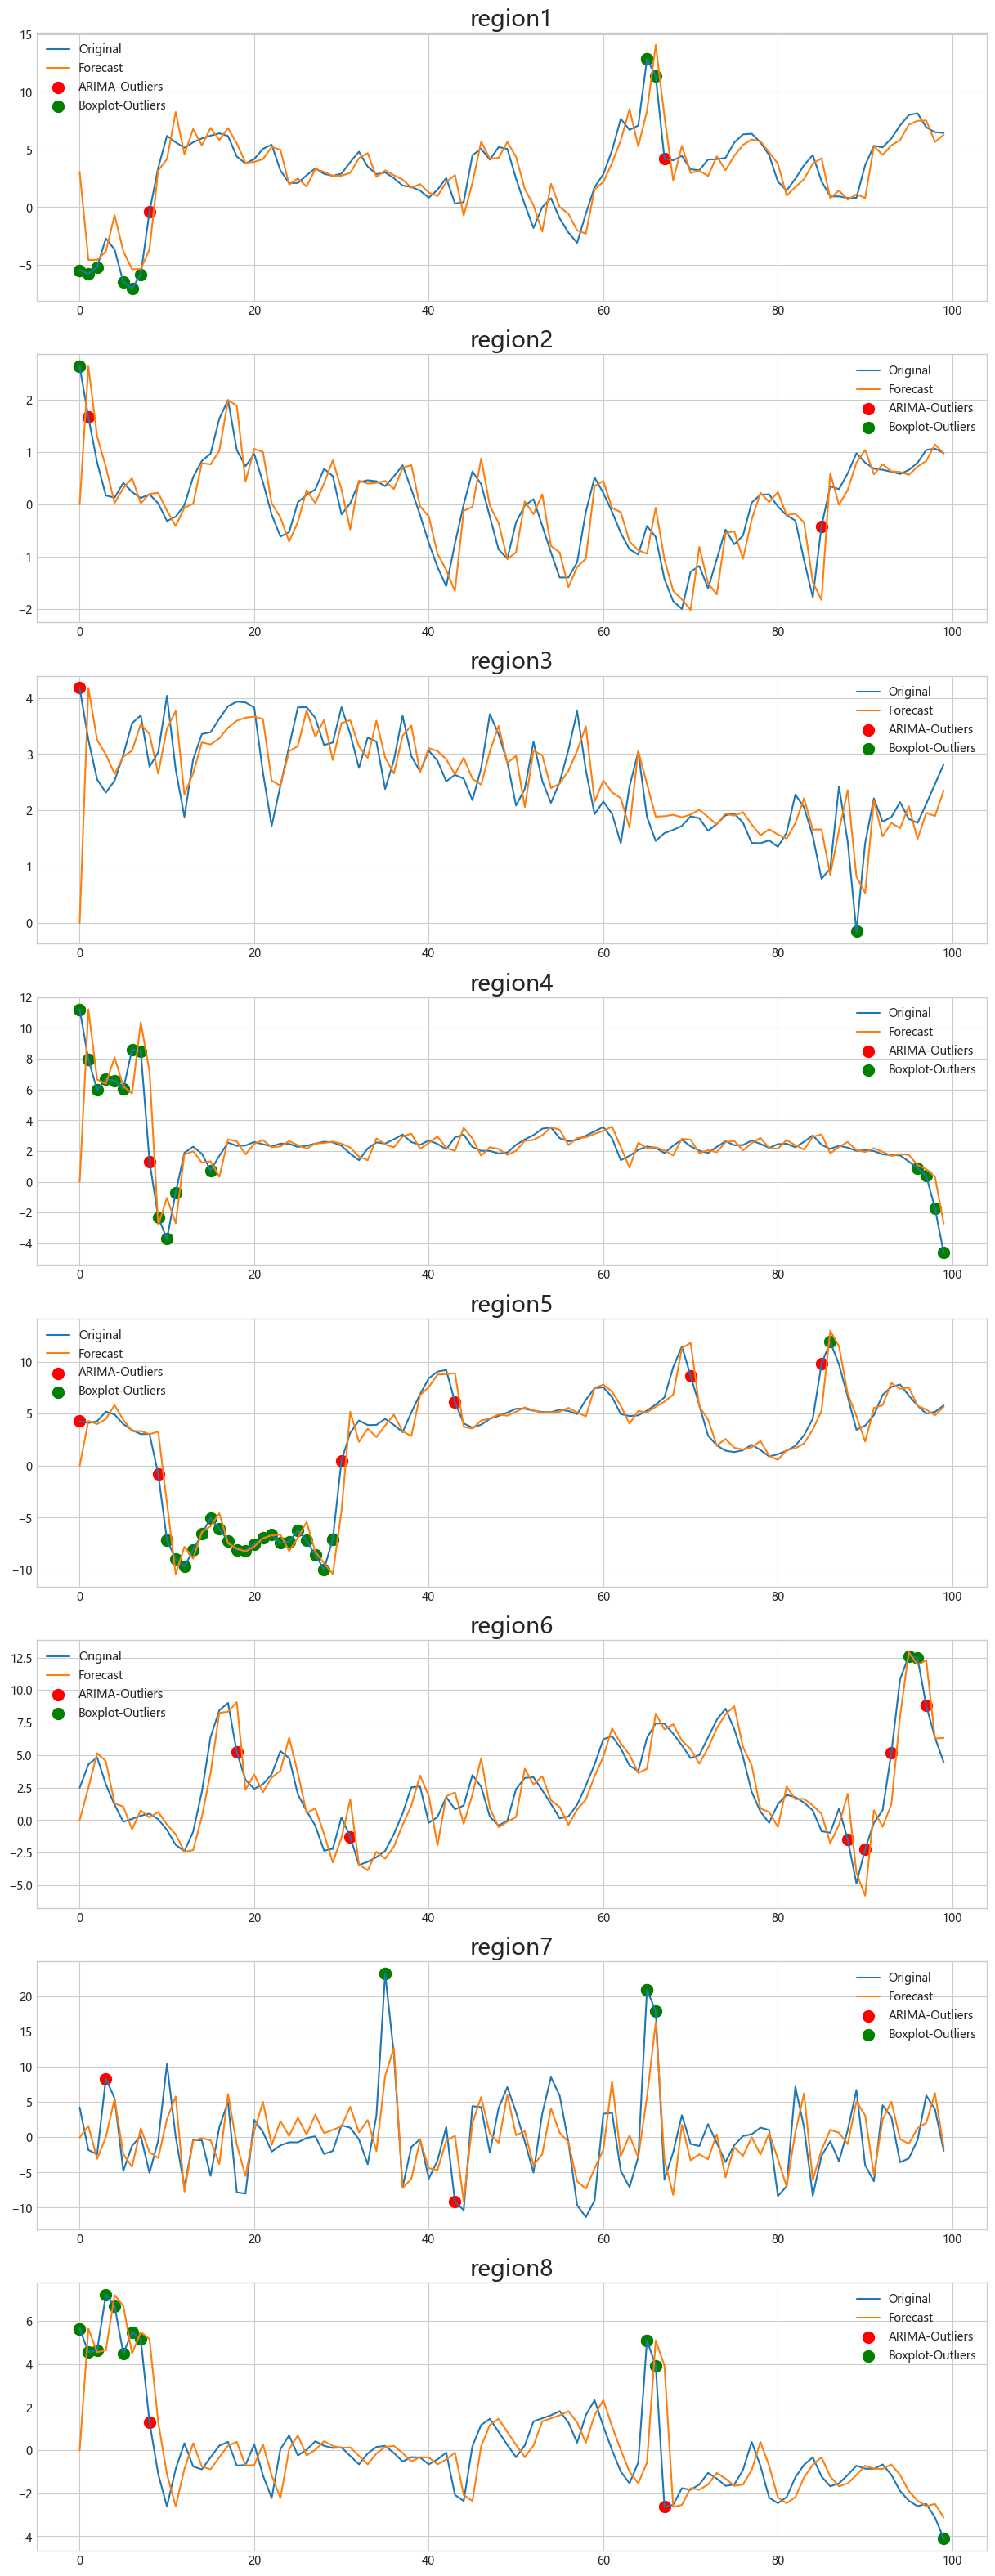

In [31]:
from pmdarima import auto_arima

# ARIMA(Autoregressive Integrated Moving Average model)差分整合移动平均自回归模型
# 模型的参数(p, d, q), 每一个元组对应一个地区的模型参数(参数的设置由ACF、PACF图和ADF检验得来)
# p: 时间序列数据本身的滞后数(属于Autoregressive model自回归模型)
# d: 数据进行差分的次数
# q: 预测误差的滞后数(属于Moving average model滑动平均模型)
param = [(2, 0, 3), (2, 1, 1), (0, 1, 2), (2, 1, 1), (2, 1, 1), (2, 1, 1), (2, 0, 2), (0, 1, 0)]

fig, ax = plt.subplots(8, 1, figsize=(15, 40))
for i in range(1, 9):
    ts = data.iloc[:, i]

    # 进行自动 ARIMA 模型拟合(想看算法拟合的参数可以把下面四行的#去掉)
    # from pmdarima import auto_arima
    # model = auto_arima(ts)
    # order = model.order
    # print(order)

    # 训练 ARIMA 模型
    model = ARIMA(ts, order=param[i - 1])
    result = model.fit()

    # 预测
    forecast = result.predict(start=0, end=len(ts)-1, typ='levels')

    ax[i-1].plot(ts, label='Original')
    ax[i-1].plot(forecast, label='Forecast')

    # 基于2σ准则判断异常点
    # 假设模型的预测值和真实值的差，即残差服从高斯分布
    diff = np.array(ts - forecast)
    diff_std = diff.std()
    diff_mean = diff.mean()

    # 不在（μ - 2σ，μ + 2σ）区间内的布尔索引，即异常值的布尔索引
    outliers = (diff_mean + 2 * diff_std < diff) | (diff < diff_mean - 2 * diff_std)

    # ARIMA模型标注的异常点为红色
    # 箱形图标注的异常点为绿色，有可能把同一个位置的红色点覆盖掉
    ax[i-1].scatter(np.arange(100)[outliers], ts[outliers], c='red', s=100, label='ARIMA-Outliers')

    # 箱形图
    q1, q3 = ts.quantile(q=[0.25, 0.75])
    iqr = q3 - q1
    outliers_index = (ts < (q1 - 1.5 * iqr)) | (ts > (q3 + 1.5 * iqr))
    ax[i-1].scatter(np.arange(100)[outliers_index], ts[outliers_index], c='green', s=100, label='Boxplot-Outliers')
    ax[i-1].set_title('region%d' % i, fontsize=20)
    ax[i-1].legend()

    # AIC和BIC指标是评估ARIMA模型的，越小越好
    # print('-'*25 + 'region' + str(i) + '-'*25)
    # # 计算模型的AIC和BIC指标
    # print('AIC:', result.aic)
    # print('BIC:', result.bic)
    # print()

# plt.savefig('图片\模型预测效果图.png')